## 1 任务概述

本次作业的目标是使用Pytorch实现一个卷积神经网络（CNN），并应用于CIFAR-10数据集进行图像分类。
CIFAR-10数据集包含10个类别的60000张32x32彩色图片，我们的任务是通过训练CNN模型，识别并分类这些图像。通过使用Pytorch框架，加载数据集并构建一个合适的神经网络架构，对图像进行训练和评估。
最后，通过计算准确率（Accuracy）和类别精度（Precision）等指标来评价模型的分类效果。

## 2 获取并组织数据集

在本节中，将通过一系列步骤获取并组织CIFAR-10数据集，以便于进行后续的图像分类任务。首先，需要从网上下载CIFAR-10数据集，并将其解压到指定目录中。接着，会对下载的原始数据进行格式处理，将原始的数字数据转换为更直观的图像形式。此外，还会从训练集中拆分出验证集，并将训练集、验证集和测试集中的图像按照标签进行分类，确保数据集的结构适用于后续的训练过程。以下分为“下载数据集”和“整理数据集”两个小节进行详细介绍。

### 2.1 导入本次作业所需的包和模块

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import tarfile
import urllib.request
import shutil
import math
import collections
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageFilter
import torch
from torch import nn
import torch.nn.functional as F
from d2l import torch as d2l
import time
from torchvision import datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


### 2.2 下载数据集

在本小节中，我的目标是从CIFAR-10官方网站[CIFAR-10 and CIFAR-100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html)中下载数据集，并将其解压到指定路径中。具体步骤包括下载`cifar-10-python.tar.gz`压缩文件，并在`./data`目录下进行解压。数据集解压后，将包含一个名为`cifar-10-batches-py`的文件夹，其中保存了训练和测试数据。

In [118]:
# 设置下载和解压路径
data_dir = './data'  # 数据保存目录
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'  # CIFAR-10数据集的下载链接
file_name = url.split('/')[-1]  # 从URL中提取文件名
file_path = os.path.join(data_dir, file_name)  # 完整的文件路径

# 创建数据目录（如果不存在）
if not os.path.exists(data_dir):
    os.makedirs(data_dir)  # 如果目录不存在，则创建数据目录

# 下载数据集（如果文件不存在）
if not os.path.exists(file_path):
    print(f"Downloading {file_name}...")  # 输出正在下载的信息
    urllib.request.urlretrieve(url, file_path)  # 从URL下载文件并保存到指定路径

# 解压数据集（如果解压后的文件夹不存在）
if not os.path.exists(os.path.join(data_dir, 'cifar-10-batches-py')):
    print(f"Extracting {file_name}...")  # 输出正在解压的信息
    with tarfile.open(file_path, 'r:gz') as tar:  # 打开下载的tar.gz文件
        tar.extractall(path=data_dir)  # 解压到指定目录
    print("Extraction completed.")  # 输出解压完成的信息

### 2.3 整理数据集

在本小节中，需要对下载的数据进行格式化处理，并将其整理成便于训练和评估的形式。数据集原始的格式为每张图片存储为一个3072维的向量，并包含图片的标签。首先，为了更直观的看到数据，我将对这些数据进行格式处理，将其转换为图像文件，并生成标签文件。然后，我会从原始训练集中拆分出后续的训练集和验证集，并按照类标签将数据分类存放在不同文件夹中，便于后续训练时加载。

#### 2.3.1 数据集格式处理

在本节中，为了更直观地看到图像，我的目标是将原始的CIFAR-10数据集中的每张图片从一个3072维的数字向量转换为32x32的RGB图像。CIFAR-10数据集中的每张图像存储为一个包含3072个整数的向量，其中前1024个数表示图像中红色通道的像素值，接下来的1024个数表示绿色通道的像素值，最后1024个数表示蓝色通道的像素值。这些值的范围是0到255，表示像素的强度。图像数据是按照行主序存储的，也就是说，前32个数字对应第一行的红色像素值，接下来的1025至1056这32个数字对应第二行的绿色像素值，最后的2049至2080这32个数字对应第一行的蓝色像素值，依此类推，直到整个32x32的图像数据被存储完成。

首先需要将每张图像的3072维数据重塑为一个32x32的矩阵，并按照RGB三个通道来分配这些数据。具体来说，将该数据重塑为一个三维的数组，其中第一维表示RGB颜色通道，第二维和第三维分别表示图像的高度和宽度。接下来，将这些重塑后的数据转换成图像格式，保存为PNG文件，以便于后续的使用。

同时，CIFAR-10数据集的图像标签存储在一个表格中，表格中标签的值是从0到9的整数，表示图像所属的类别。标签和图像一一对应，我会将这些标签保存到CSV文件中，其格式包括两列：`id`表示图像的序号，`true_labels`表示对应的真实标签。通过这种方式，可将训练集和测试集的标签分别保存在`trainLabels.csv`和`testLabels.csv`文件中，以便后续对比和验证模型的预测结果。

在实现过程中，将遍历训练集和测试集中的每一张图像，使用`PIL`库将重塑后的图像数据保存为PNG文件，并将图像的标签保存到相应的CSV文件中。通过这样的操作，所有的图像和标签都被正确地组织并保存，便于后续的数据加载和模型训练。

In [119]:
# 定义unpickle函数，用于加载CIFAR-10数据集中的二进制文件
def unpickle(file):
    # 打开并读取二进制文件
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')  # 载入文件并返回字典
    print("Keys in the dataset:", dict.keys())  # 打印字典中的键
    return dict  # 返回字典

# 读取并保存图像数据集的函数
def save_images(data_dir='./data/cifar-10-batches-py'):
    # 创建存储图像的目录（训练集和测试集）
    if not os.path.exists('./data/cifar-10/train'):
        os.makedirs('./data/cifar-10/train')  # 如果没有train目录，则创建它
    if not os.path.exists('./data/cifar-10/test'):
        os.makedirs('./data/cifar-10/test')  # 如果没有test目录，则创建它

    # 初始化存储训练数据和标签的列表
    all_train_data = []  # 用于存储所有训练图像数据
    all_train_labels = []  # 用于存储所有训练图像的标签

    # 读取data_batch_1到data_batch_5
    for i in range(1, 6):
        train_data_path = os.path.join(data_dir, f'data_batch_{i}')  # 构建每个训练批次的文件路径
        train_batch = unpickle(train_data_path)  # 加载当前批次的数据

        # 获取数据和标签
        train_data = train_batch.get(b'data')  # 获取图像数据
        train_labels = train_batch.get(b'labels')  # 获取标签数据

        # 检查数据和标签是否存在
        if train_data is None or train_labels is None:
            raise KeyError("The data or labels key is missing in the loaded batch.")

        # 将数据和标签添加到合并的列表中
        all_train_data.append(train_data)  # 将当前批次的图像数据添加到训练数据列表中
        all_train_labels.append(train_labels)  # 将当前批次的标签添加到标签列表中

    # 读取测试集数据
    test_data_path = os.path.join(data_dir, 'test_batch')  # 测试集的路径
    test_batch = unpickle(test_data_path)  # 加载测试集

    # 获取测试数据和标签
    test_data = test_batch.get(b'data')
    test_labels = test_batch.get(b'labels')

    # 检查测试数据和标签是否存在
    if test_data is None or test_labels is None:
        raise KeyError("The data or labels key is missing in the test batch.")

    # 合并所有训练数据
    all_train_data = np.concatenate(all_train_data)  # 合并所有训练集的图像数据
    all_train_labels = np.concatenate(all_train_labels)  # 合并所有训练集的标签

    # 合并训练集和测试集
    all_data = np.concatenate((all_train_data, test_data))  # 合并训练集和测试集的图像数据
    all_labels = np.concatenate((all_train_labels, test_labels))  # 合并训练集和测试集的标签

    # 保存训练集图像
    for i, img_data in enumerate(all_train_data):
        # 将图像数据从一维数组转换为3通道32x32的图像
        img = np.reshape(img_data, (3, 32, 32)).transpose(1, 2, 0)
        img = Image.fromarray(img)  # 创建图像对象
        
        # 保存图像到训练集目录
        img.save(f'./data/cifar-10/train/{i+1}.png')

    # 保存测试集图像
    for i, img_data in enumerate(test_data):
        # 将图像数据从一维数组转换为3通道32x32的图像
        img = np.reshape(img_data, (3, 32, 32)).transpose(1, 2, 0)
        img = Image.fromarray(img)  # 创建图像对象
        
        # 保存图像到测试集目录
        img.save(f'./data/cifar-10/test/{i+1}.png')

    # 将训练集标签保存到CSV文件
    train_labels_df = pd.DataFrame({'id': np.arange(1, len(all_train_labels) + 1), 'true_labels': all_train_labels})
    train_labels_df.to_csv('./data/cifar-10/trainLabels.csv', index=False)  # 保存标签为CSV格式

    # 将测试集标签保存到CSV文件
    test_labels_df = pd.DataFrame({'id': np.arange(1, len(test_labels) + 1), 'true_labels': test_labels})
    test_labels_df.to_csv('./data/cifar-10/testLabels.csv', index=False)  # 保存标签为CSV格式

    # 创建results.csv文件，其中的'prediction_labels'列将在后续的预测中更新，初始为空
    # 先读取测试集的标签
    test_labels_df = pd.read_csv('./data/cifar-10/testLabels.csv')

    # 构建results.csv的初始内容，'prediction_labels'列先为空
    results_df = test_labels_df.copy()  # 创建一个副本
    results_df['prediction_labels'] = np.nan  # 添加一个空的预测标签列

    # 保存到results.csv
    results_df.to_csv('./data/cifar-10/results.csv', index=False)


# 调用保存图像的函数
save_images()  # 执行保存图像和标签的操作


Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Keys in the dataset: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


#### 2.3.2 验证集拆分

为了在训练过程中对模型进行验证，需要从训练集中拆分出一个验证集。验证集的作用是在模型训练过程中提供一个独立于训练数据的评估数据集，通过验证集上的表现来选择最优的模型以及调整模型的超参数，防止模型过拟合。验证集的大小由`valid_ratio`参数控制，这个比率决定了从训练集中分配到验证集的样本比例。通常，验证集的大小占总训练集的一个固定比例，常见的设置是10%或者20%，这里设置为**10%**。

具体的拆分过程要求保证每个类别至少有一张图片被选入验证集，以确保验证集的类别分布能够较为均衡，且能够有效评估模型在不同类别上的表现。为了实现这一目标，我需要采取一种基于类别数量的分配策略。首先，令`n`表示训练集某个类别中的样本数，`r`是预先设定的验证集比率。根据这个比率，可以为每个类别计算出需要从中拆分出来的验证集样本数量，即通过计算`n * r`得到每个类别的验证样本数。由于样本数通常不是整数，需要取这个值的下取整，即使用`floor(n * r)`，这样可以保证验证集的样本数不会超过该类别在训练集中的样本数。

然而，在某些情况下，可能会出现样本较少的类别，导致计算得到的验证集样本数为0。为了避免这种情况，要求每个类别至少有1张图像被选入验证集。这就需要对每个类别的验证集样本数应用一个下界，即对于每个类别，验证集的样本数应该是 $\max(\lfloor nr\rfloor,1)$ ，即取每个类别计算得到的验证集样本数与1中的较大者，确保每个类别至少有一张图像进入验证集。

通过这种方法，我们能够根据训练集中的每个类别的样本数量，动态地计算出每个类别应该分配到验证集中的样本数，并确保每个类别的验证集样本数不为零。拆分后的验证集、训练集和测试集将分别存放在不同的文件夹中，确保数据集的结构清晰且便于后续的训练和评估工作。最终，通过调整`valid_ratio`，我们可以灵活地控制验证集的大小，进而影响模型选择和超参数调整的效果。

In [120]:
# 将文件复制到目标目录
def copyfile(filename, target_dir):
    """将文件复制到目标目录"""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

# 将验证集从原始的训练集中拆分出来
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))  # 每个类别验证集的样本数
    label_count = {}  # 用于统计每个类别已经拆分的验证集样本数
    
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]  # 从文件名中获取类别标签
        fname = os.path.join(data_dir, 'train', train_file)  # 获取文件的完整路径
        
        # 将文件复制到 train_valid 目录中的训练集或验证集
        if label not in label_count or label_count[label] < n_valid_per_label:
            # 如果该类别的验证集还没有达到所需数量，则将图片复制到验证集文件夹
            copyfile(fname, os.path.join(data_dir, 'train_valid', 'valid', str(label)))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 否则，将图片复制到训练集文件夹
            copyfile(fname, os.path.join(data_dir, 'train_valid', 'train', str(label)))
    
    return n_valid_per_label

# 主函数，重组织CIFAR-10数据集
def reorg_cifar10_data(data_dir, valid_ratio):
    # 读取训练集标签
    labels = pd.read_csv(os.path.join(data_dir, 'trainLabels.csv'))
    labels = {str(row['id']): row['true_labels'] for _, row in labels.iterrows()}
    
    # 创建train_valid目录结构
    if not os.path.exists(os.path.join(data_dir, 'train_valid')):
        os.makedirs(os.path.join(data_dir, 'train_valid'))
        os.makedirs(os.path.join(data_dir, 'train_valid', 'train'))
        os.makedirs(os.path.join(data_dir, 'train_valid', 'valid'))
    
    # 拆分训练集和验证集
    n_valid_per_label = reorg_train_valid(data_dir, labels, valid_ratio)
    
    print(f"Validation set per label: {n_valid_per_label}")
    
# 调用函数，传入数据路径和验证集比例（例如valid_ratio=0.1）
reorg_cifar10_data('./data/cifar-10', valid_ratio=0.1)


Validation set per label: 500


#### 2.3.3 数据集统计输出

在拆分完成后，输出训练集、验证集和测试集中的样本数量以及各类别数据量分布。

In [122]:
def dataset_summary():
    # 统计训练集样本数量，并按类别显示
    train_samples = 0  # 记录训练集总样本数
    train_class_count = {}  # 用于存储训练集中每个类别的样本数
    for label in range(10):  # 假设数据集有10个类别
        class_dir = os.path.join('./data/cifar-10/train_valid/train', str(label))  # 每个类别的目录路径
        class_sample_count = len(os.listdir(class_dir))  # 获取该类别目录下的文件数，即该类别样本数
        train_samples += class_sample_count  # 累加到训练集总样本数
        train_class_count[label] = class_sample_count  # 记录每个类别的样本数

    # 统计验证集样本数量，并按类别显示
    valid_samples = 0  # 记录验证集总样本数
    valid_class_count = {}  # 用于存储验证集中每个类别的样本数
    for label in range(10):  # 假设验证集有10个类别
        class_dir = os.path.join('./data/cifar-10/train_valid/valid', str(label))  # 每个类别的验证集目录路径
        class_sample_count = len(os.listdir(class_dir))  # 获取该类别目录下的文件数，即该类别样本数
        valid_samples += class_sample_count  # 累加到验证集总样本数
        valid_class_count[label] = class_sample_count  # 记录每个类别的样本数

    # 统计测试集样本数量，并按类别分布
    test_samples = 0  # 记录测试集总样本数
    test_class_count = {i: 0 for i in range(10)}  # 用于存储测试集各类别的样本数，初始化为0

    # 读取测试集标签文件
    test_labels = pd.read_csv('./data/cifar-10/testLabels.csv')  # 假设测试集标签文件是CSV格式
    
    # 统计每个类别的样本数
    for label in test_labels['true_labels']:  # 假设标签列名为'true_labels'
        test_class_count[label] += 1  # 增加该类别的样本数
        test_samples += 1  # 累加测试集总样本数

    # 输出每个类别的样本数量及总数
    print(f"训练样本 : {train_samples} 条")  # 输出训练集样本总数
    for label, count in train_class_count.items():  # 输出每个类别的样本数
        print(f"类别 {label} : {count} 条")

    print(f"验证样本 : {valid_samples} 条")  # 输出验证集样本总数
    for label, count in valid_class_count.items():  # 输出每个类别的样本数
        print(f"类别 {label} : {count} 条")

    print(f"测试样本 : {test_samples} 条")  # 输出测试集样本总数
    for label, count in test_class_count.items():  # 输出每个类别的样本数
        print(f"类别 {label} : {count} 条")

# 调用统计函数
dataset_summary()


训练样本 : 45000 条
类别 0 : 4500 条
类别 1 : 4500 条
类别 2 : 4500 条
类别 3 : 4500 条
类别 4 : 4500 条
类别 5 : 4500 条
类别 6 : 4500 条
类别 7 : 4500 条
类别 8 : 4500 条
类别 9 : 4500 条
验证样本 : 5000 条
类别 0 : 500 条
类别 1 : 500 条
类别 2 : 500 条
类别 3 : 500 条
类别 4 : 500 条
类别 5 : 500 条
类别 6 : 500 条
类别 7 : 500 条
类别 8 : 500 条
类别 9 : 500 条
测试样本 : 10000 条
类别 0 : 1000 条
类别 1 : 1000 条
类别 2 : 1000 条
类别 3 : 1000 条
类别 4 : 1000 条
类别 5 : 1000 条
类别 6 : 1000 条
类别 7 : 1000 条
类别 8 : 1000 条
类别 9 : 1000 条


#### 2.3.4 可视化展示数据集

为了直观展示数据集的内容，我们可以查看每个类中第一张图片。

Displaying samples from the train set:


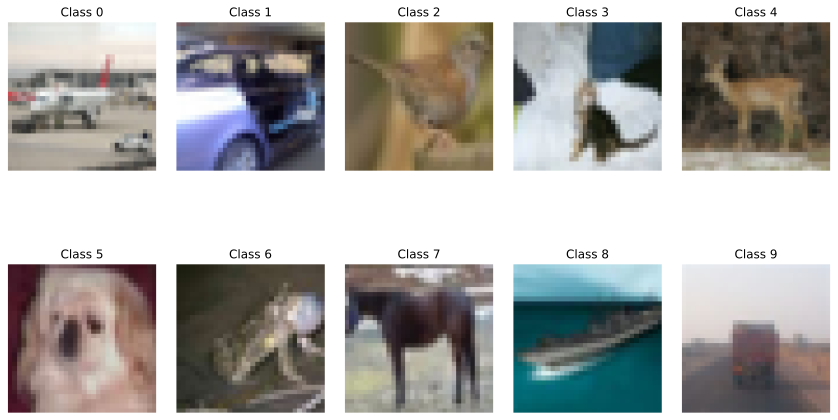

Displaying samples from the valid set:


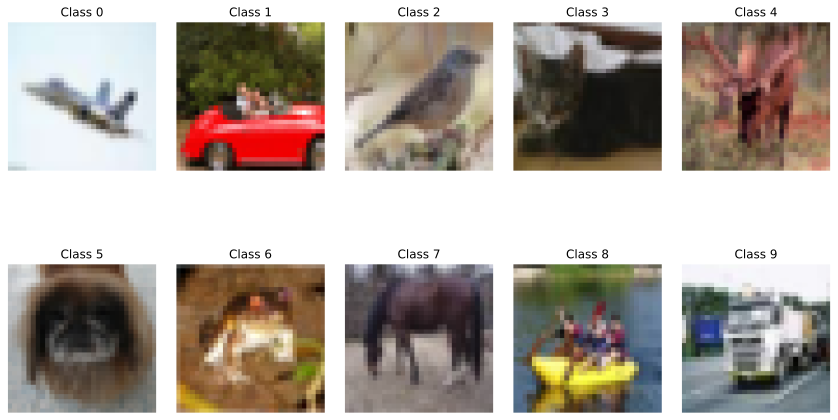

In [124]:
def show_samples_in_directory(data_dir, categories=10):
    """
    该函数用于在给定目录中展示每个类别的第一张图片。
    参数：
    - data_dir: 数据集所在的根目录。
    - categories: 类别的数量，默认值为10（用于CIFAR-10数据集）。
    """
    # 创建 2 行 5 列的网格，最多显示 10 张图像
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))  # 创建2x5的子图布局，调整figsize使图像显示紧凑
    axes = axes.ravel()  # 将axes数组展平，方便通过索引访问每个子图
    
    # 展示每个类别的第一张图片
    img_count = 0  # 用于计数展示的图片数量
    for label in range(categories):  # 遍历每个类别（假设有10个类别）
        # 获取当前类别文件夹中的所有图像文件
        class_dir = os.path.join(data_dir, str(label))  # 获取每个类别的目录路径
        images = os.listdir(class_dir)  # 获取该类别文件夹中的所有图像文件名
        
        # 确保每个类别有图片
        if images:
            # 加载当前类别的第一张图片
            img = mpimg.imread(os.path.join(class_dir, images[0]))  # 读取图片
            
            # 获取当前的轴并展示图像
            axes[img_count].imshow(img)  # 在相应的子图中展示图片
            axes[img_count].set_title(f'Class {label}')  # 设置该子图的标题为当前类别
            axes[img_count].axis('off')  # 不显示坐标轴
            
            img_count += 1  # 增加已展示图片的计数
            if img_count >= 10:  # 最多展示10张图像（2行5列）
                break
    
    # 调整布局并减少间距
    plt.subplots_adjust(wspace=0.1, hspace=0.1)  # 调整子图之间的水平和垂直间距
    plt.tight_layout(pad=2.0)  # 增加一些填充以避免子图标题或图像重叠
    plt.show()  # 显示图像

def show_samples():
    """
    该函数用于展示训练集和验证集中的每个类别的第一张图片。
    """
    # 展示训练集的第一张图片
    print("Displaying samples from the train set:")  # 输出提示信息
    show_samples_in_directory('./data/cifar-10/train_valid/train')  # 调用函数展示训练集图片
    
    # 展示验证集的第一张图片
    print("Displaying samples from the valid set:")  # 输出提示信息
    show_samples_in_directory('./data/cifar-10/train_valid/valid')  # 调用函数展示验证集图片

# 调用可视化函数，展示训练集和验证集中的每个类别的第一张图片
show_samples()  # 调用show_samples函数，展示训练集和验证集的样本图像


### 2.4 本节小结

In [125]:
# 定义一个函数来加载batches.meta文件，获取类别名称
def load_label_names(meta_file='./data/cifar-10-batches-py/batches.meta'):
    """
    该函数加载 CIFAR-10 数据集中的 'batches.meta' 文件，并获取类别名称。
    
    参数：
    - meta_file: 'batches.meta' 文件的路径，默认为 './data/cifar-10-batches-py/batches.meta'。
    
    返回：
    - label_names: 一个包含类别名称的列表。
    """
    # 加载batches.meta文件
    with open(meta_file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')  # 读取并解码pickle文件中的数据
    
    # 获取类别名称，'label_names'是batches.meta中的一个键
    label_names = meta_data[b'label_names']
    
    # 将字节类型的类别名称转换为字符串列表
    label_names = [name.decode('utf-8') for name in label_names]  # 解码字节数据为utf-8格式的字符串
    return label_names  # 返回类别名称列表

# 打印类别名称和对应的类别标签
def print_class_names():
    """
    该函数调用load_label_names函数，获取类别名称，并打印每个类别的标签及对应名称。
    """
    # 获取类别名称
    label_names = load_label_names('./data/cifar-10-batches-py/batches.meta')
    
    # 打印类别名称和对应标签
    print("由原始数据集./data/cifar-10-batches-py/batches.meta可知各类别标签对应的类别为：")
    for i, label_name in enumerate(label_names):  # 遍历类别名称列表
        print(f'Class {i} 对应类别为"{label_name}"')  # 打印每个类别的标签和名称

# 调用打印函数，输出类别名称及其对应标签
print_class_names()  # 调用函数并打印类别信息


由原始数据集./data/cifar-10-batches-py/batches.meta可知各类别标签对应的类别为：
Class 0 对应类别为"airplane"
Class 1 对应类别为"automobile"
Class 2 对应类别为"bird"
Class 3 对应类别为"cat"
Class 4 对应类别为"deer"
Class 5 对应类别为"dog"
Class 6 对应类别为"frog"
Class 7 对应类别为"horse"
Class 8 对应类别为"ship"
Class 9 对应类别为"truck"


由此可知，可视化展示数据集的结果符合batches.meta对于各类别标签的描述，从而验证了数据集整理阶段代码的正确性，同时也为后续的模型训练提供了对数据集的直观了解。

数据集整理完毕后，./data/cifar-10下有以下文件：
- ./data/cifar-10/test：测试集，共10000张图片，每个图片大小为32x32x3
- ./data/cifar-10/train：训练集，共50000张图片，每个图片大小为32x32x3
- ./data/cifar-10/train_valid：切分后的训练集和验证集，./data/cifar-10/train_valid下有两个文件夹：train和valid，分别存放切分后训练集和验证集，其中：
    - ./data/cifar-10/train_valid/train：切分后的训练集，共45000张图片，下有0-9共10个子文件夹，每个子文件夹下存放属于该类别的图片
    - ./data/cifar-10/train_valid/valid：切分后的验证集，共5000张图片，下有0-9共10个子文件夹，每个子文件夹下存放属于该类别的图片
- ./data/cifar-10/testLables.csv：测试集标签文件，共10000行，每行对应一张测试图片的id和标签，标签为0-9的整数
- ./data/cifar-10/trainLabels.csv：训练集标签文件，共50000行，每行对应一张训练图片的id和标签，标签为0-9的整数
- ./data/cifar-10/results.csv：存放模型最终的评估结果，包含三列内容：图片id、真实标签true_labels和预测标签prediction_labels

## 3 图像增强

为了提高模型的泛化能力，并有效防止在训练过程中出现过拟合现象，本节将对训练数据应用图像增强技术。通过对图像执行一系列随机变化操作，如随机翻转、随机裁剪、色彩增强及标准化等，可以让模型在不同版本的图像上学习，从而增强其对未知数据的适应性。在验证和测试阶段，为了确保评估结果的一致性和公平性，只进行必要的标准化处理。本节内容分为两部分，首先介绍训练和验证阶段的数据增强方法，然后介绍验证和测试阶段的标准化处理，所有增强策略均以函数的形式定义，便于后续数据读取模块直接调用。

### 3.1 训练阶段数据增强

在训练阶段，为了丰富训练样本的多样性，采用了多种数据增强策略。具体包括：随机水平翻转、随机裁剪、色彩增强（调整亮度、对比度和饱和度）、旋转、锐化以及标准化处理。随机水平翻转和旋转操作能有效模拟不同方向的变化，进一步增加数据的多样性；随机裁剪则能模拟视角变化；色彩增强通过调节亮度、对比度和饱和度，使模型对光照变化更加鲁棒；平移操作允许图像在水平和垂直方向上发生小幅位移，增强了模型对位置变化的适应能力；通过锐化处理提升图像清晰度，使细节更加突出，有助于增强图像的可辨识性。最后，对RGB三个通道执行标准化处理，使不同样本在像素分布上保持一致，从而加快模型收敛速度。

以下是对训练阶段的图像增强函数定义：

In [126]:
# 定义训练和验证阶段的图像增强函数
def train_augment():
    """训练阶段的数据增强"""
    # 使用transforms.Compose将多个图像变换操作链式连接在一起
    transform_train = transforms.Compose([
        # 随机将图像扩展到40像素后随机裁剪为32像素
        transforms.Resize(40),  # 先将图像缩放至40像素，确保图像大小适合进行后续操作
        transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),  # 随机裁剪为32x32大小，裁剪区域占原图面积的64%至100%

        # 随机水平翻转
        transforms.RandomHorizontalFlip(),  # 随机水平翻转图像，增强模型的鲁棒性

        # 图像平移（随机水平和垂直平移）
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机对图像进行水平和垂直方向的平移，平移的范围为原图宽高的10%

        # 随机旋转
        transforms.RandomRotation(degrees=15),  # 随机旋转图像，旋转角度范围为-15到15度

        # 随机调整图像的亮度、对比度和饱和度
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # 随机调整图像的亮度、对比度和饱和度，增强图像的多样性

        # 增强图像清晰度：使用锐化滤镜
        transforms.Lambda(lambda img: img.filter(ImageFilter.SHARPEN)),  # 使用PIL中的锐化滤镜增强图像的清晰度

        # 转为Tensor
        transforms.ToTensor(),  # 将图像转换为Tensor格式，方便输入到PyTorch模型中

        # 标准化处理
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # 进行图像标准化，确保每个通道的像素值在相似的范围内
                             std=[0.2023, 0.1994, 0.2010])  # 使用CIFAR-10数据集的均值和标准差进行标准化
    ])
    return transform_train  # 返回数据增强的转换操作


### 3.2 验证和测试阶段数据标准化

在验证和测试阶段，为了消除模型评估过程中因随机增强引入的偏差，仅对测试图像进行标准化处理。标准化使每个通道的像素值分布具有相同的均值和标准差，从而有助于模型稳定地进行推理并获得可靠的性能指标。不同于训练阶段，这里不进行随机翻转、裁剪或色彩增强，以确保测试结果具有可重复性和公平性。

以下是验证和测试阶段的图像标准化函数定义：

In [129]:
# 定义测试阶段的数据标准化函数
def test_augment():
    """测试阶段的数据标准化"""
    # 使用transforms.Compose将多个图像变换操作链式连接在一起
    transform_test = transforms.Compose([
        # 将图像转换为Tensor格式
        transforms.ToTensor(),  # 将PIL图像或numpy.ndarray转换为PyTorch的Tensor格式，方便输入到模型中

        # 对图像进行标准化处理
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # 使用CIFAR-10数据集的均值进行标准化
                             std=[0.2023, 0.1994, 0.2010])  # 使用CIFAR-10数据集的标准差进行标准化
    ])
    
    # 返回数据标准化的转换操作
    return transform_test


## 4 读取数据集

本节主要实现从整理好的本地图像文件和标签中读取数据，并结合前面定义的图像增强操作，生成可供训练、验证和测试使用的数据集对象。读取过程中不仅要正确关联图像与标签，还需要根据不同阶段应用不同的数据增强策略。为了便于后续训练，在读取数据后，还将使用PyTorch的`DataLoader`模块构建数据迭代器，统一批量加载数据，提升数据处理效率。本节分为“数据读取及增强”和“数据迭代器构建”两个小节展开。

### 4.1 数据读取及增强

在本小节中，首先分别读取切分后的训练集、验证集和测试集，以及完整的训练集。读取过程中，训练集（包括完整的训练集）将应用随机裁剪、翻转、色彩增强及标准化等图像增强操作，以提高模型的鲁棒性。而验证集和测试集则只进行标准化处理，以消除推理阶段的随机性。同时，通过自定义Dataset对象，确保每个读取的样本包含一张处理后的图片和一个对应的标签。完成后，将形成四个数据集对象：`train_dataset`、`valid_dataset`、`train_all_dataset` 和 `test_dataset`，为后续训练和评估提供数据支持。

以下是数据读取及增强的代码实现：

In [130]:
# 自定义Dataset类，适用于train_all和test这种从CSV读取标签的场景
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_csv, transform=None):
        """
        初始化CIFAR10Dataset类
        
        参数：
        - img_dir: 图片所在的目录，存放图像文件
        - labels_csv: csv文件路径，包含id和true_labels列，其中id是图像文件名的标识符，true_labels是该图像的标签
        - transform: 图像增强或标准化操作（可选）
        """
        self.img_dir = img_dir  # 图像文件所在目录
        self.transform = transform  # 图像增强操作
        self.labels = pd.read_csv(labels_csv)  # 读取CSV文件，包含图像ID和标签
    
    def __len__(self):
        """
        返回数据集的长度，即图像的数量
        """
        return len(self.labels)  # 数据集的长度即为CSV文件中的行数
    
    def __getitem__(self, idx):
        """
        获取索引idx对应的图像及其标签
        
        参数：
        - idx: 数据集中的索引
        
        返回：
        - image: 图像数据
        - label: 图像的标签
        """
        img_id = self.labels.iloc[idx, 0]  # 获取图像ID
        label = self.labels.iloc[idx, 1]  # 获取图像的标签
        img_path = os.path.join(self.img_dir, f'{img_id}.png')  # 构建图像文件的路径
        image = Image.open(img_path)  # 打开图像文件
        
        # 如果有图像增强操作，则进行图像增强
        if self.transform:
            image = self.transform(image)
        
        return image, label  # 返回处理后的图像和标签

# 设置数据目录
data_dir = './data/cifar-10'  # 设置数据集的根目录

# 读取切分后的训练集（包含图像增强操作）
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train_valid/train'),
                                      transform=train_augment())  # 使用train_augment函数进行图像增强操作

# 读取切分后的验证集（仅进行标准化处理）
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train_valid/valid'),
                                      transform=test_augment())  # 使用test_augment函数进行标准化处理

# 读取完整训练集（包括验证集），这里使用自定义的CIFAR10Dataset类，并进行图像增强操作
train_all_dataset = CIFAR10Dataset(img_dir=os.path.join(data_dir, 'train'),
                                   labels_csv=os.path.join(data_dir, 'trainLabels.csv'),
                                   transform=train_augment())  # 传入图像目录和标签CSV，进行图像增强

# 读取测试集（仅进行标准化处理），使用自定义的CIFAR10Dataset类
test_dataset = CIFAR10Dataset(img_dir=os.path.join(data_dir, 'test'),
                              labels_csv=os.path.join(data_dir, 'testLabels.csv'),
                              transform=test_augment())  # 传入图像目录和标签CSV，进行标准化处理


### 4.2 数据迭代器构建

为了提高数据读取和训练效率，本小节将构建适用于训练、验证和测试的数据迭代器（DataLoader）。通过设置统一的`batch_size`参数（本次作业中设为 **64**），可以方便地批量处理数据，同时通过`shuffle`参数控制是否在每个epoch打乱数据顺序，从而提升训练的泛化性能。对于训练集和验证集，我们开启数据打乱（`shuffle=True`）并设置`drop_last=True`，丢弃最后不足一个批量的小样本，保证每个小批次的数据量一致，从而加快训练过程中的并行计算和提升Batch Normalization等操作的稳定性；对于测试和验证集，则不打乱顺序（`shuffle=False`），并且保留最后的小批次（`drop_last=False`），确保评估时使用全部样本，提高评估的准确性和完整性。最终将形成四个数据迭代器：`train_iter`、`valid_iter`、`train_all_iter` 和 `test_iter`，为模型训练和测试提供连续的数据输入。

以下是数据迭代器构建的代码实现：

In [143]:
# 设置批量大小
batch_size = 64  # 每个批次包含64个样本

# 构建训练集的数据加载器（打乱数据，丢弃最后一个不足batch大小的小批量）
train_iter = DataLoader(train_dataset,  # 使用train_dataset作为数据源
                        batch_size=batch_size,  # 设置批量大小
                        shuffle=True,  # 打乱数据，确保训练集的样本顺序不一致
                        drop_last=True)  # 如果最后一个批次不足batch大小，则丢弃该批次

# 构建验证集的数据加载器（不打乱数据，不丢弃最后一个小批量）
valid_iter = DataLoader(valid_dataset,  # 使用valid_dataset作为数据源
                        batch_size=batch_size,  # 设置批量大小
                        shuffle=False,  # 不打乱数据，验证集需要按顺序进行评估
                        drop_last=False)  # 保留最后一个小批次，即使它的样本数不足batch大小

# 构建完整训练集的数据加载器（打乱数据，丢弃最后一个不足batch大小的小批量）
train_all_iter = DataLoader(train_all_dataset,  # 使用train_all_dataset作为数据源
                            batch_size=batch_size,  # 设置批量大小
                            shuffle=True,  # 打乱数据，确保训练集的样本顺序不一致
                            drop_last=True)  # 如果最后一个批次不足batch大小，则丢弃该批次

# 构建测试集的数据加载器（不打乱数据，不丢弃最后一个小批量）
test_iter = DataLoader(test_dataset,  # 使用test_dataset作为数据源
                       batch_size=batch_size,  # 设置批量大小
                       shuffle=False,  # 不打乱数据，测试集需要按顺序进行评估
                       drop_last=False)  # 保留最后一个小批次，即使它的样本数不足batch大小


## 5 定义模型

本节将实现一个经典的卷积神经网络——ResNet18。ResNet网络通过引入残差块的概念解决了传统深度神经网络在训练时出现的“梯度消失”问题。通过残差连接的引入，使得网络可以训练更深的层，并且能够显著提高训练的效率和效果。在“ResNet网络与残差块”小节中，将简要介绍ResNet的原理，并具体分析其核心组件——残差块。在“网络搭建”小节中会基于PyTorch实现ResNet18网络结构，并展示每个网络层的功能和作用。

### 5.1 ResNet网络与残差块

ResNet（Residual Network）是由微软研究院提出的深度卷积神经网络，获得了2015年ImageNet图像分类竞赛的冠军，其提出了一种有效缓解深度神经网络中“梯度消失”问题的方法。在传统的深层神经网络中，随着网络深度增加，梯度在反向传播过程中会逐渐趋近于0，导致模型训练困难，性能下降。这种现象称为“梯度消失”。

ResNet通过引入 **残差块（Residual Block）** 解决了这一问题。具体地，残差块将输入$x$直接加到输出$y$上，使得网络学习的是输入与输出之间的**残差**。在梯度反向传播时，残差块可以使梯度变为$\left(\frac{dy}{dx} + 1\right)$，从而避免梯度消失问题。这一创新使得可以训练极深的网络而不会出现训练困难。如下图所示是ResNet的基础架构–残差块（residual block），可以看到，在残差块中，输入可通过跨层数据线路更快地向前传播，这是因为残差块的结构通常包括两个卷积层和一个跳跃连接，输入通过两个卷积层计算得到输出后，再与输入相加，得到最终的输出。这样一来，梯度在反向传播时，能够直接从后面几层传递回前面几层，不会因为层数过深而导致梯度消失。

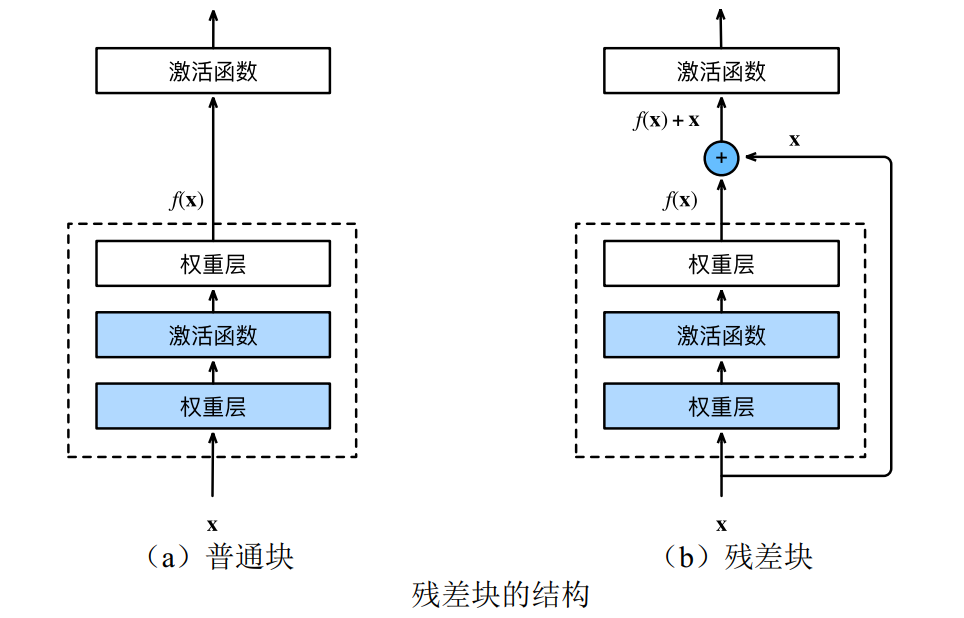

### 5.2 网络搭建

本节将实现一个ResNet18模型，由于ResNet18仅由18层网络组成，具有较浅的网络结构，适合在CIFAR-10这样的较小数据集上进行训练。ResNet-18的特点是使用了多个残差块，每个块内部包含两层卷积操作。整体网络先进行一个7x7卷积与池化操作，然后逐步通过4个残差模块，最终使用全局平均池化和全连接分类器输出10个类别的结果。这里需要用到d2l这个包，因为它是 Dive into Deep Learning（动手学深度学习） 这本书的官方代码包，它的名字全称叫 d2l，提供了很多简单易用的工具函数，比如：计时器（Timer）、动态绘图器（Animator）、精度计算（accuracy）、累加器（Accumulator）、评估验证集准确率（evaluate_accuracy_gpu） 等等。

In [139]:
# 定义残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        """
        初始化残差块，定义了两个卷积层，使用1x1卷积来匹配输入和输出的形状。
        
        参数：
        - input_channels: 输入通道数
        - num_channels: 输出通道数
        - use_1x1conv: 是否使用1x1卷积来匹配输入和输出的形状
        - strides: 卷积步长
        """
        super().__init__()
        # 第一个卷积层，使用3x3卷积核，填充为1，步长为strides
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3,
                               padding=1, stride=strides)
        # 第二个卷积层，使用3x3卷积核，填充为1，步长为1
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3,
                               padding=1)
        # 如果需要使用1x1卷积来匹配输入和输出的形状，则定义1x1卷积层
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1,
                                   stride=strides)
        else:
            self.conv3 = None  # 否则不使用1x1卷积
        # 定义批量归一化层
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        """
        前向传播函数，定义了残差块的操作流程。
        
        参数：
        - X: 输入数据
        
        返回：
        - 经过残差块处理后的数据
        """
        # 经过第一层卷积、批量归一化和ReLU激活函数
        Y = F.relu(self.bn1(self.conv1(X)))
        # 经过第二层卷积和批量归一化
        Y = self.bn2(self.conv2(Y))
        # 如果使用1x1卷积，则调整输入的形状
        if self.conv3:
            X = self.conv3(X)
        # 返回残差连接后的结果，通过ReLU激活函数
        return F.relu(Y + X)

# 构建ResNet-18网络
def resnet18(num_classes=10):
    """
    构建ResNet-18网络架构。
    
    参数：
    - num_classes: 网络最终输出的类别数（默认为10类）
    
    返回：
    - net: 完整的ResNet-18网络模型
    """
    # 定义ResNet中的一个残差块
    def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
        """
        构建一个ResNet模块，包括多个残差块。
        
        参数：
        - input_channels: 输入通道数
        - num_channels: 输出通道数
        - num_residuals: 该模块中残差块的数量
        - first_block: 是否是第一个残差块（第一个残差块需要使用1x1卷积进行形状匹配）
        
        返回：
        - blk: 包含多个残差块的模块
        """
        blk = []
        for i in range(num_residuals):
            # 如果是第一个残差块，并且不是第一个模块，需要使用1x1卷积来匹配形状
            if i == 0 and not first_block:
                blk.append(Residual(input_channels, num_channels,
                                    use_1x1conv=True, strides=2))  # 步长为2，进行下采样
            else:
                blk.append(Residual(num_channels, num_channels))  # 其余的残差块
        return blk

    # 定义ResNet的结构
    net = nn.Sequential(
        # 第一层卷积，7x7卷积，步长为2，填充为3，输入为3通道图像
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),  # 批量归一化
        nn.ReLU(),  # ReLU激活函数
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 最大池化层，3x3卷积核，步长为2，填充为1
    )

    # 添加四个残差模块
    net.add_module("resnet_block1", nn.Sequential(*resnet_block(64, 64, 2, first_block=True)))  # 第一个模块包含2个残差块
    net.add_module("resnet_block2", nn.Sequential(*resnet_block(64, 128, 2)))  # 第二个模块包含2个残差块
    net.add_module("resnet_block3", nn.Sequential(*resnet_block(128, 256, 2)))  # 第三个模块包含2个残差块
    net.add_module("resnet_block4", nn.Sequential(*resnet_block(256, 512, 2)))  # 第四个模块包含2个残差块

    # 添加全局平均池化层
    net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module("fc", nn.Flatten())  # 扁平化操作，将输出展平
    net.add_module("linear", nn.Linear(512, num_classes))  # 全连接层，将512个特征映射到类别数

    return net

# 创建ResNet-18模型
net = resnet18()

# 创建一个输入数据张量，形状为(1, 3, 32, 32)，表示1张32x32的RGB图像
X = torch.randn(size=(1, 3, 32, 32))

# 切换到推理模式（评估模式）
net.eval()

# 禁用梯度计算（推理阶段不需要计算梯度）
with torch.no_grad():
    print("Input shape:", X.shape)  # 输出输入张量的形状
    # 遍历网络中的每一层并打印每一层的输出形状
    for name, layer in net.named_children():
        X = layer(X)  # 将输入张量传递给每一层
        print(f"{name}: output shape {X.shape}")  # 输出当前层的名称和输出张量的形状


Input shape: torch.Size([1, 3, 32, 32])
0: output shape torch.Size([1, 64, 16, 16])
1: output shape torch.Size([1, 64, 16, 16])
2: output shape torch.Size([1, 64, 16, 16])
3: output shape torch.Size([1, 64, 8, 8])
resnet_block1: output shape torch.Size([1, 64, 8, 8])
resnet_block2: output shape torch.Size([1, 128, 4, 4])
resnet_block3: output shape torch.Size([1, 256, 2, 2])
resnet_block4: output shape torch.Size([1, 512, 1, 1])
global_avg_pool: output shape torch.Size([1, 512, 1, 1])
fc: output shape torch.Size([1, 512])
linear: output shape torch.Size([1, 10])


### 5.3 网络各层次概述

通过上个代码块的打印输出，可以看到每一层的输出尺寸逐步减小，直至最终变为$1\times1$大小后进入全连接分类器，如下图所示，描述了完整的 **ResNet-18** 网络中各层的处理流程。

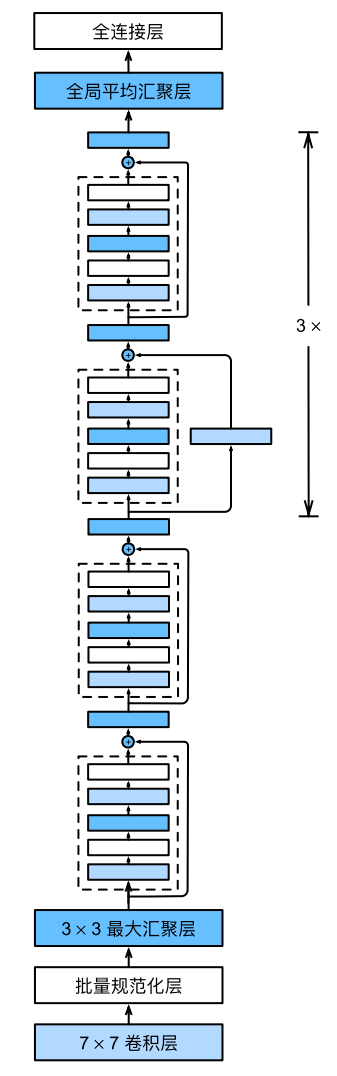

首先，输入的图像尺寸是 `(1, 3, 32, 32)`，表示批次大小为1，通道数为3（RGB图像），高度和宽度为32x32。

1. **初始卷积层 (`Conv2d`)**：
    输入图像通过一个大小为 7x7，步长为 2 的卷积核进行处理。这个操作不仅提取图像的局部特征，还通过步长为2的设置对图像进行下采样。经过这一层后，输出的特征图尺寸变为 `(1, 64, 16, 16)`，即通道数为64，高度和宽度都减少了（图像被压缩）。
2. **BatchNorm 和 ReLU**：
    接着，经过批归一化（`BatchNorm2d`）和激活函数ReLU的处理，网络进一步调整了特征图的分布，并引入非线性变化。该操作对通道数为64的特征图进行标准化和非线性激活，使得后续的学习更加稳定和高效。
3. **最大池化 (`MaxPool2d`)**：
    然后是最大池化层，采用3x3的池化窗口，步长为2，这个操作使得特征图的大小进一步减半，从 `(1, 64, 16, 16)` 变为 `(1, 64, 8, 8)`，同时保持了重要的特征信息。
4. **残差块 (`resnet_block1`, `resnet_block2`, `resnet_block3`, `resnet_block4`)**：
    接下来的四个残差块是ResNet的核心。每个残差块由多个 `Residual` 模块组成，每个模块包括两个卷积层及其批归一化层。通过引入跳跃连接，残差块使得网络更深的同时解决了梯度消失问题。在每个残差块中，特征图的通道数不断增加，并且尺寸逐渐减小。具体来说，`resnet_block1` 通过两个卷积层将通道数保持为64，并且特征图大小仍为 `(1, 64, 8, 8)`。进入 `resnet_block2` 后，通道数增加到128，尺寸减半为 `(1, 128, 4, 4)`。在 `resnet_block3` 中，通道数增加至256，尺寸为 `(1, 256, 2, 2)`。最后，在 `resnet_block4` 中，通道数达到512，特征图的大小被进一步压缩至 `(1, 512, 1, 1)`。
5. **全局平均池化 (`global_avg_pool`)**：
    在残差块之后，应用了全局平均池化层，旨在对每个通道的特征图进行池化，将每个通道的 `1x1` 特征图平均化为单一的数值，这使得每个通道输出一个标量。因此，特征图的大小从 `(1, 512, 1, 1)` 保持不变，但只剩下每个通道一个值，结果尺寸变为 `(1, 512, 1, 1)`。
6. **展平 (`fc`，`Flatten`)**：
    展平层将经过池化的特征图展平成一个一维向量，尺寸由 `(1, 512, 1, 1)` 变为 `(1, 512)`，为后续的全连接层准备数据。
7. **全连接层 (`linear`)**：
    最后，经过一个全连接层，输出层的维度为10，对应10个类别的分类任务。因此，最终的输出是 `(1, 10)`，每个值表示每个类别的得分，网络通过softmax函数将其转化为概率值。

该网络从输入的32x32图像开始，经过一系列卷积操作、残差模块、池化和标准化，最终通过全连接层输出每个类别的得分。同时，该网络的深度和残差连接确保了其良好的学习能力，能够处理更复杂的图像数据。

## 6 定义训练函数

为了高效、灵活地训练CNN模型，需要定义一个通用的训练函数，能够适配带有或不带有验证集的两种场景，并动态调整学习率，记录训练过程中的损失值和准确率变化，从而实现对ResNet18模型的训练与验证。训练过程将包括：定义损失函数、优化器、学习率调度器以及每个epoch中的训练和验证过程。

训练函数接收多个参数，包括：`net`（待训练的网络模型），`train_iter`（训练数据迭代器），`valid_iter`（验证数据迭代器），`num_epochs`（训练轮数），`lr`（学习率），`wd`（权重衰减），`devices`（计算设备，如GPU编号），`lr_period`（学习率调整周期），`lr_decay`（学习率衰减倍数）。训练中使用带动量的SGD优化器，并采用`StepLR`每隔指定周期调整学习率，以提升训练效果并避免陷入局部最优。

In [140]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    """
    训练函数，用于训练神经网络，包含模型训练、损失计算、准确率评估以及学习率调度。
    
    参数：
    - net: 需要训练的网络模型
    - train_iter: 训练集的 DataLoader
    - valid_iter: 验证集的 DataLoader（如果有）
    - num_epochs: 训练的总轮数
    - lr: 初始学习率
    - wd: 权重衰减（L2正则化）
    - devices: 设备列表（如GPU列表）
    - lr_period: 学习率调度的周期
    - lr_decay: 学习率衰减的因子
    """
    # 使用SGD优化器，设置学习率，动量和权重衰减（L2正则化）
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    # 学习率调度器，每过lr_period个epoch就衰减学习率，衰减因子为lr_decay
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, step_size=lr_period, gamma=lr_decay)

    # 获取训练集的批次数量
    num_batches = len(train_iter)
    epoch_logs = []  # 存储每个epoch的日志
    legend = ['train loss', 'train acc']  # 图表中显示训练损失和训练准确率
    if valid_iter is not None:
        legend.append('valid acc')  # 如果有验证集，添加验证准确率

    # 设置图像大小，显示训练过程中的数据
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend, figsize=(10, 6))

    # 将模型放置到多个GPU上（如果有的话）
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 定义交叉熵损失函数
    loss = nn.CrossEntropyLoss(reduction="none")

    # 记录整个训练过程的开始时间
    total_start_time = time.time()

    for epoch in range(num_epochs):
        # 设置模型为训练模式
        net.train()
        # 使用d2l的Accumulator来累加损失、准确率和样本数
        metric = d2l.Accumulator(3)  # train loss, train acc, num examples
        # 记录当前epoch的开始时间
        epoch_start_time = time.time()

        for i, (features, labels) in enumerate(train_iter):
            # 将数据放到对应设备上（例如GPU）
            features, labels = features.to(devices[0]), labels.to(devices[0])
            # 清空优化器的梯度
            trainer.zero_grad()
            # 前向传播：计算预测值
            preds = net(features)
            # 计算损失
            l = loss(preds, labels)
            # 反向传播：计算梯度
            l.mean().backward()
            # 更新模型参数
            trainer.step()
            # 计算准确率，并累加损失、准确率和样本数
            with torch.no_grad():
                metric.add(l.sum(), d2l.accuracy(preds, labels), labels.numel())

            # 每隔一段时间（根据批次数的比例），更新图像
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None if valid_iter is None else 0))

        # 记录当前epoch的结束时间
        epoch_end_time = time.time()
        # 计算一个epoch的耗时
        epoch_duration = epoch_end_time - epoch_start_time

        # 保存当前epoch的训练损失和准确率
        epoch_log = f"Epoch {epoch + 1}, Train Loss: {metric[0] / metric[2]:.4f}, " \
                    f"Train Accuracy: {metric[1] / metric[2]:.3f}, Epoch Time: {epoch_duration:.2f} secs"
        epoch_logs.append(epoch_log)
        # 输出当前epoch的日志
        print(epoch_log, flush=True)

        # 如果验证集可用，计算并输出验证准确率
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            print(f"Validation Accuracy: {valid_acc:.3f}", flush=True)
            # 更新图像中验证准确率的显示
            animator.add(epoch + 1, (None, None, valid_acc))

        # 更新学习率
        scheduler.step()

    # 记录训练结束的时间
    total_end_time = time.time()
    # 计算整个训练过程的总耗时
    total_time = total_end_time - total_start_time

    # 计算并输出最终训练损失和准确率
    train_loss = metric[0] / metric[2]
    train_acc = metric[1] / metric[2]
    print(f"\n最终训练情况为：")
    print(f"训练损失：{train_loss:.4f}, 训练准确率：{train_acc:.3f}")
    if valid_iter is not None:
        print(f"验证准确率：{valid_acc:.3f}")
    print(f"训练过程总耗时：{total_time:.2f}秒")

    # 显示整个训练过程的日志
    for log in epoch_logs:
        print(log)
    
    # 显示训练过程中的图像
    plt.show()


## 7 训练和验证模型

在这一小节中，需要调用上面定义的训练函数，在切分好的训练集和验证集上进行实际的训练和验证模型。通过自由调整超参数如学习率、权重衰减、周期、学习率衰减率等，并通过观察实时绘制的训练过程曲线来判断模型是否收敛或出现过拟合，我们希望能够通过训练得到一个高效的模型。


最终训练情况为：
训练损失：0.4765, 训练准确率：0.830
验证准确率：0.826
训练过程总耗时：2082.06秒
Epoch 1, Train Loss: 1.9262, Train Accuracy: 0.313, Epoch Time: 47.40 secs
Epoch 2, Train Loss: 1.6167, Train Accuracy: 0.415, Epoch Time: 36.89 secs
Epoch 3, Train Loss: 1.4386, Train Accuracy: 0.481, Epoch Time: 38.89 secs
Epoch 4, Train Loss: 1.3119, Train Accuracy: 0.535, Epoch Time: 39.85 secs
Epoch 5, Train Loss: 1.2070, Train Accuracy: 0.570, Epoch Time: 39.71 secs
Epoch 6, Train Loss: 1.1390, Train Accuracy: 0.598, Epoch Time: 39.26 secs
Epoch 7, Train Loss: 1.0819, Train Accuracy: 0.620, Epoch Time: 39.73 secs
Epoch 8, Train Loss: 1.0332, Train Accuracy: 0.636, Epoch Time: 39.57 secs
Epoch 9, Train Loss: 0.9842, Train Accuracy: 0.656, Epoch Time: 39.55 secs
Epoch 10, Train Loss: 0.9448, Train Accuracy: 0.670, Epoch Time: 39.39 secs
Epoch 11, Train Loss: 0.9151, Train Accuracy: 0.678, Epoch Time: 39.10 secs
Epoch 12, Train Loss: 0.8929, Train Accuracy: 0.689, Epoch Time: 39.74 secs
Epoch 13, Train Loss: 0.8584, Tra

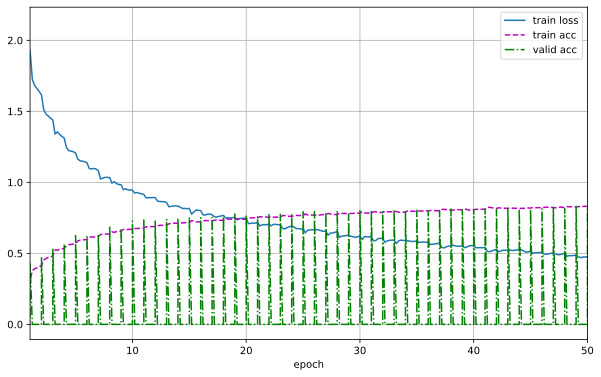

In [144]:
# 训练超参数设置
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 50, 0.01, 5e-4
# devices: 选择可用的所有GPU设备（如果有GPU的话）
# num_epochs: 设置训练的总轮数，这里是50轮
# lr: 初始学习率，设置为0.01
# wd: 权重衰减（L2正则化）的系数，设置为5e-4

lr_period, lr_decay, net = 4, 0.9, resnet18()
# lr_period: 每4轮进行一次学习率衰减
# lr_decay: 每次衰减时，学习率乘以0.9（即学习率衰减因子）
# net: 初始化ResNet-18模型

# 启动训练过程
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)
# 调用train函数，开始训练模型
# 参数说明：
# - net: 要训练的模型（这里是ResNet-18）
# - train_iter: 训练集的DataLoader
# - valid_iter: 验证集的DataLoader
# - num_epochs: 训练的总轮数
# - lr: 初始学习率
# - wd: 权重衰减系数
# - devices: 使用的设备（GPU或CPU）
# - lr_period: 学习率衰减周期（每4轮衰减一次）
# - lr_decay: 学习率衰减因子（每次衰减时，学习率乘以0.9）


模型训练50个周期，在这50个周期中，学习率每隔4个周期乘以0.9衰减一次。训练过程中，动态绘制训练损失、训练准确率以及验证准确率曲线，便于实时观察模型训练状态。

这里的valid acc曲线震荡如此巨大的原因，**推测大概率是batch_size（32）设置过小引起的波动**，使用较小的批次大小会导致每个批次的梯度更新极为不稳定。因为**每个小批次中的数据量较少，模型在每次更新时对数据的拟合较为随机**，很大程度上会导致验证准确率在每个周期之间有较大的波动。而且**小批量更新的梯度噪声比较大**，可能在训练过程中引入更大的不确定性，最终导致了valid acc曲线震荡如此严重。

我经过多次尝试，发现**将batch_size设置为512后，valid acc曲线的震荡不再明显，模型的训练状态也更加稳定**，但随之而来的结果是模型在验证集上的准确率不高；**如果将batch_size设置为本次实验中的64，则valid acc曲线的震荡虽会更加明显，但模型在验证集上的准确率会有显著提升**，我认为这主要是由于更低的batch_size使得模型在每次更新时更为随机、不确定性更大，从而降低了模型**过拟合**的风险，因此在验证集上的准确率才会很高。

## 8 完整训练数据集训练和测试模型

经过在训练集与验证集上调整超参数后，本节将使用**完整训练集**（包括之前划分的验证集）重新训练模型，以充分利用所有数据。完成训练后，保存模型并在测试集上进行评估，输出准确率与各类别Precision，并保存预测结果到`results.csv`文件中。

Epoch 50, Train Loss: 0.4756, Train Accuracy: 0.833, Epoch Time: 48.00 secs

最终训练情况为：
训练损失：0.4756, 训练准确率：0.833
训练过程总耗时：2486.99秒
Epoch 1, Train Loss: 1.8340, Train Accuracy: 0.339, Epoch Time: 46.79 secs
Epoch 2, Train Loss: 1.5694, Train Accuracy: 0.435, Epoch Time: 47.38 secs
Epoch 3, Train Loss: 1.3875, Train Accuracy: 0.504, Epoch Time: 48.40 secs
Epoch 4, Train Loss: 1.2585, Train Accuracy: 0.554, Epoch Time: 48.82 secs
Epoch 5, Train Loss: 1.1598, Train Accuracy: 0.593, Epoch Time: 44.90 secs
Epoch 6, Train Loss: 1.1015, Train Accuracy: 0.613, Epoch Time: 45.42 secs
Epoch 7, Train Loss: 1.0501, Train Accuracy: 0.633, Epoch Time: 44.93 secs
Epoch 8, Train Loss: 1.0039, Train Accuracy: 0.648, Epoch Time: 74.25 secs
Epoch 9, Train Loss: 0.9501, Train Accuracy: 0.670, Epoch Time: 75.06 secs
Epoch 10, Train Loss: 0.9177, Train Accuracy: 0.680, Epoch Time: 50.28 secs
Epoch 11, Train Loss: 0.8924, Train Accuracy: 0.688, Epoch Time: 50.83 secs
Epoch 12, Train Loss: 0.8630, Train Accuracy:

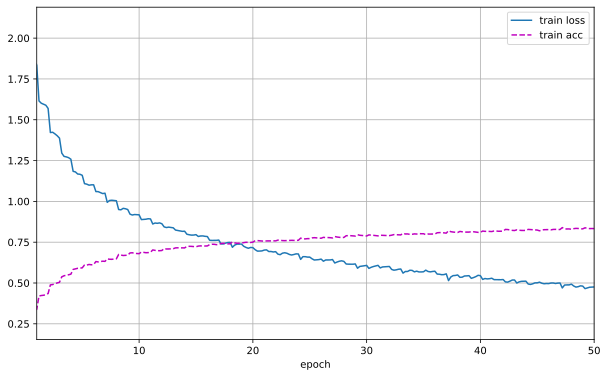


完整训练集得到的网络模型mycifarmodel.pth在测试集上的准确率为：83.260%
各个类别的Precision为： [0.8424591738631849, 0.911111111101908, 0.8363431151147139, 0.7229488703837937, 0.8040345821248412, 0.7670396744581176, 0.8444863336395431, 0.8576923076840607, 0.8836081474211096, 0.8360957642648611]
模型预测详细预测情况已输出至./data/cifar-10/results.csv的predictionLabels列。


In [146]:
# 重新训练，使用完整训练集
net = resnet18()  # 初始化ResNet-18模型
# 调用train函数，使用完整训练集进行训练，这里没有验证集（valid_iter传递为None）
train(net, train_all_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

# 保存训练好的模型
torch.save(net.state_dict(), './mycifarmodel.pth')  # 将训练好的模型权重保存到文件中

# 评估模型在测试集上的准确率和各类别Precision
def evaluate_on_test(net, test_iter, device=torch.device('cuda')):
    """
    在测试集上评估模型的准确率和每个类别的Precision。

    参数：
    - net: 训练好的网络模型
    - test_iter: 测试集的DataLoader
    - device: 使用的设备，默认是CUDA设备（GPU）

    返回：
    - accuracy: 测试集的准确率
    - precisions: 每个类别的精确度（Precision）
    - ids: 测试集样本的索引
    - y_true: 测试集的真实标签
    - y_pred: 测试集的预测标签
    """
    net = nn.DataParallel(net, device_ids=[device.index]).to(device)  # 将模型放到指定设备上，支持多GPU
    net.eval()  # 设置模型为评估模式，关闭BatchNorm和Dropout等层的特殊操作
    y_true, y_pred, ids = [], [], []  # 初始化真实标签、预测标签和样本索引列表

    with torch.no_grad():  # 禁用梯度计算，评估时不需要计算梯度
        for idx, (features, labels) in enumerate(test_iter):  # 遍历测试集
            features, labels = features.to(device), labels.to(device)  # 将数据移到指定设备上
            preds = net(features).argmax(axis=1)  # 获取每个样本的预测类别（使用argmax获取最大值对应的类别）
            
            # 存储当前批次的样本索引，直接使用idx作为样本的ID
            ids.extend([idx] * features.size(0))  # 为每个样本存储其索引
            y_true.extend(labels.cpu().numpy())  # 获取真实标签并转换为numpy数组
            y_pred.extend(preds.cpu().numpy())  # 获取预测标签并转换为numpy数组

    y_true, y_pred = np.array(y_true), np.array(y_pred)  # 转换为numpy数组
    accuracy = (y_true == y_pred).sum() / len(y_true)  # 计算测试集的准确率

    # 计算每个类别的Precision
    precisions = []
    for c in range(10):  # 假设有10个类别
        tp = ((y_pred == c) & (y_true == c)).sum()  # 真阳性：预测和真实标签均为类别c
        fp = ((y_pred == c) & (y_true != c)).sum()  # 假阳性：预测为类别c，真实标签不是类别c
        precision = tp / (tp + fp + 1e-8)  # 计算精确度，防止分母为0
        precisions.append(precision)

    return accuracy, precisions, ids, y_true, y_pred  # 返回准确率、各类别精确度、索引、真实标签和预测标签

# 加载模型并评估
net.load_state_dict(torch.load('./mycifarmodel.pth'))  # 加载保存的模型权重
# 评估模型在测试集上的准确率和每个类别的精确度
test_accuracy, precisions, ids, y_true, y_pred = evaluate_on_test(net, test_iter)

# 输出模型在测试集上的准确率
print(f"\n完整训练集得到的网络模型mycifarmodel.pth在测试集上的准确率为：{test_accuracy*100:.3f}%")
# 输出每个类别的Precision
print("各个类别的Precision为：", precisions)

# 更新results.csv文件，保存模型预测结果
results_df = pd.read_csv('./data/cifar-10/results.csv')  # 读取已有的结果CSV文件

# 确保CSV文件中包含'id'和'true_labels'列
results_df['prediction_labels'] = y_pred  # 将模型的预测标签添加到'prediction_labels'列

# 将更新后的DataFrame保存回CSV文件
results_df.to_csv('./data/cifar-10/results.csv', index=False)  # 不保存索引列

# 输出预测保存的提示信息
print("模型预测详细预测情况已输出至./data/cifar-10/results.csv的predictionLabels列。")


## 9 小结

在本次作业中，我使用Pytorch框架实现了一个卷积神经网络（CNN），并将其应用于CIFAR-10数据集的图像分类。首先，通过编写代码下载并解压CIFAR-10数据集，接着将数据进行格式化处理，将每张图片从3072维的向量转换为32x32的RGB图像，并拆分出了训练集和验证集。此外，应用数据增强技术，如随机水平翻转、随机裁剪等，以提高模型的泛化能力。模型设计上，我选择的是ResNet-18网络，通过残差块来解决梯度消失问题，确保了网络能够训练得更深且稳定。在训练过程中，我使用了带动量的SGD优化器，并结合学习率衰减策略，使得模型能够更好地收敛。完成训练和验证后，我将训练好的模型保存，并在测试集上进行了评估，得到了模型在测试集上的准确率和各个类别上的精度。

最终，我将模型的预测结果保存到`results.csv`文件中，通过这个过程我深刻理解了如何从数据处理到模型训练再到评估的完整流程，提高了自己在数据处理和模型训练中的实操能力。